In [41]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import tensorflow as tf

In [42]:
np.random.seed(42)
tf.random.set_seed(42)

In [43]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dropout, Dense, GlobalAveragePooling1D
from tensorflow.keras.layers import Layer, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

In [44]:
# Data directory
DATADIR = 'UCI HAR Dataset'

In [45]:
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [46]:
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'{DATADIR}/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).to_numpy()
        ) 

    return np.transpose(signals_data, (1, 2, 0))

In [47]:
def load_y(subset):
    filename = f'{DATADIR}/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).to_numpy()

In [48]:
def load_data():
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [49]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [50]:
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [51]:
X_train, X_test, Y_train, Y_test = load_data()

In [52]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


In [53]:
X_train.shape

(7352, 128, 9)

In [54]:
# TCN Layer
def TCN(input_layer, filters, kernel_size=3, dilation_rate=1):
    x = Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal')(input_layer)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal')(x)
    x = Activation('relu')(x)
    return x


In [55]:
# Self-Attention Layer
class SelfAttention(Layer):
    def __init__(self, units):
        super(SelfAttention, self).__init__()
        self.units = units
        self.query_dense = Dense(units)
        self.key_dense = Dense(units)
        self.value_dense = Dense(units)

    def call(self, inputs):
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        attention_scores = tf.matmul(query, key, transpose_b=True)
        attention_scores = attention_scores / tf.math.sqrt(tf.cast(self.units, tf.float32))
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        output = tf.matmul(attention_weights, value)
        return output
    
    def get_config(self):
        # Return the configuration of the custom layer
        config = super(SelfAttention, self).get_config()
        config.update({
            "units": self.units
        })
        return config


In [56]:
input_layer = Input(shape=(timesteps, input_dim))

tcn_output = TCN(input_layer, filters=64, kernel_size=3, dilation_rate=2)

attention_output = SelfAttention(units=64)(tcn_output)

x = GlobalAveragePooling1D()(attention_output)

x = Dropout(0.5)(x)

output_layer = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 9)]          0         
                                                                 
 conv1d_4 (Conv1D)           (None, 128, 64)           1792      
                                                                 
 activation_4 (Activation)   (None, 128, 64)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 128, 64)           12352     
                                                                 
 activation_5 (Activation)   (None, 128, 64)           0         
                                                                 
 self_attention_2 (SelfAtten  (None, 128, 64)          12480     
 tion)                                                           
                                                           

In [57]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [58]:
model.fit(X_train, Y_train, batch_size=16, epochs=30, validation_data=(X_test, Y_test), callbacks=[early_stopping])


Epoch 1/30
460/460 [==============================] - 12s 19ms/step - loss: 0.4086 - accuracy: 0.8428 - val_loss: 0.3679 - val_accuracy: 0.8761
Epoch 2/30
460/460 [==============================] - 8s 18ms/step - loss: 0.1467 - accuracy: 0.9421 - val_loss: 0.3559 - val_accuracy: 0.8884
Epoch 3/30
460/460 [==============================] - 8s 17ms/step - loss: 0.1294 - accuracy: 0.9472 - val_loss: 0.3308 - val_accuracy: 0.9002
Epoch 4/30
460/460 [==============================] - 8s 18ms/step - loss: 0.1234 - accuracy: 0.9464 - val_loss: 0.3455 - val_accuracy: 0.9080
Epoch 5/30
460/460 [==============================] - 8s 18ms/step - loss: 0.1153 - accuracy: 0.9518 - val_loss: 0.4072 - val_accuracy: 0.8931
Epoch 6/30
460/460 [==============================] - 8s 18ms/step - loss: 0.1132 - accuracy: 0.9553 - val_loss: 0.3875 - val_accuracy: 0.9104
Epoch 7/30
460/460 [==============================] - 8s 18ms/step - loss: 0.1137 - accuracy: 0.9525 - val_loss: 0.4028 - val_accuracy: 0.911

93/93 [==============================] - 1s 11ms/step - loss: 0.3308 - accuracy: 0.9002
Accuracy: 0.900237500667572
Loss: 0.3307574987411499
93/93 [==============================] - 1s 9ms/step


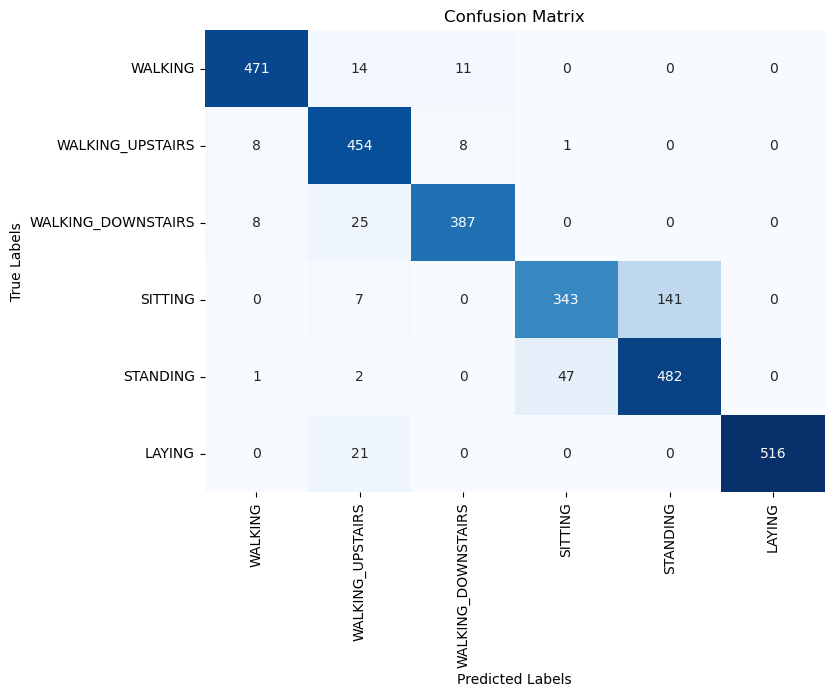

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

score = model.evaluate(X_test, Y_test)
print(f"Accuracy: {score[1]}")
print(f"Loss: {score[0]}")

y_pred = model.predict(X_test)
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"], yticklabels=["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"], cbar=False)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

plt.show()


In [60]:
model.save('skripshit_model.h5')